# Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

In [ ]:
pip install audiomentations -q

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/genriflow')

from preprocessing import load_and_process_gtzan

X_train, X_test, X_val, y_train, y_test, y_val = load_and_process_gtzan(
    gtzan_path='/content/drive/MyDrive/gtzan_dataset/Data/genres_original',
    output_file = "/content/drive/MyDrive/Colab Notebooks/genriflow/processed_data.pkl",
    n_songs_per_genre=100,
    noise='weak',
    n_augmentations=0
)


In [ ]:
import pickle

with open("/content/drive/MyDrive/Colab Notebooks/genriflow/processed_data.pkl", "rb") as f:
    data_dict = pickle.load(f)

# Now you can access the data like this
X_train = data_dict['X_train']
X_test = data_dict['X_test']
X_val = data_dict['X_val']
y_train = data_dict['y_train']
y_test = data_dict['y_test']
y_val = data_dict['y_val']

print("Data loaded successfully!")

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("X_val shape:", X_val.shape)

# Starting Inference

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Transpose to (samples, time_steps, features)
X_train_tensor = torch.tensor(X_train.transpose(0, 2, 1), dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.transpose(0, 2, 1), dtype=torch.float32)
X_val_tensor = torch.tensor(X_val.transpose(0, 2, 1), dtype=torch.float32)

print(X_train_tensor.shape)
# Encode labels if categorical
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)
y_val_encoded = le.transform(y_val)
# Convert labels into tensor
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)
y_val_tensor = torch.tensor(y_val_encoded, dtype=torch.long)
# Create DataLoader for batching
train_data = TensorDataset(X_train_tensor, y_train_tensor)
test_data = TensorDataset(X_test_tensor, y_test_tensor)
val_data = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)
# Define the LSTM Model with multiple layers
class MusicLSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, cnn_out_channels=32, kernel_size=2, num_layers=2):
        super(MusicLSTMClassifier, self).__init__()
        # Define the layers
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers, batch_first=True)

        # 1D CNN after LSTM
        self.conv1d = nn.Conv1d(in_channels=hidden_size, out_channels=cnn_out_channels, kernel_size=kernel_size, padding=kernel_size//2)

        # Fully connected layers
        self.fc1 = nn.Linear(cnn_out_channels, 64)
        self.fc2 = nn.Linear(64, num_classes)

        # Activation and pooling
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)  # Global max pooling over time

    def forward(self, x):
        # x: (batch_size, sequence_length, input_size)

        # Pass through LSTM
        lstm_out, _ = self.lstm(x)  # (batch_size, sequence_length, hidden_size)

        # Rearrange for CNN: (batch_size, hidden_size, sequence_length)
        lstm_out = lstm_out.permute(0, 2, 1)

        # Pass through CNN
        conv_out = self.conv1d(lstm_out)  # (batch_size, cnn_out_channels, sequence_length)
        conv_out = self.relu(conv_out)

        # Global Max Pooling over time dimension
        pooled = self.pool(conv_out).squeeze(-1)  # (batch_size, cnn_out_channels)

        # Fully connected layers
        x = self.relu(self.fc1(pooled))
        x = self.fc2(x)

        return x

# Initialize the model, loss function, and optimizer
input_size = X_train_tensor.shape[2]  # Number of features
hidden_size = 256  # You can tune this
num_classes = len(le.classes_)  # Number of unique classes in the labels
num_layers = 2  # Number of LSTM layers (you can increase or decrease this)
model = MusicLSTMClassifier(input_size, hidden_size, num_classes, cnn_out_channels=32, kernel_size=2, num_layers=2)
model = model.to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For multi-class classification
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=7e-3)
# Define the accuracy threshold for stopping
ACCURACY_THRESHOLD = 98
# Training the model
num_epochs = 700

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        loss.backward()  # Backpropagation

        optimizer.step()  # Update the weights

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

        running_loss += loss.item()

    train_accuracy = correct_preds / total_preds * 100
    train_loss = running_loss / len(train_loader)
    # Validation evaluation
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_correct += (predicted == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total * 100
    val_loss = val_running_loss / len(val_loader)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    if train_accuracy >= ACCURACY_THRESHOLD:
        print(f"Stopping early: Accuracy threshold {ACCURACY_THRESHOLD}% reached.")
        break

save_path = "/content/drive/MyDrive/Colab Notebooks/genriflow/music_lstm_model.pth"
torch.save(model.state_dict(), save_path)
print(f"Model saved to {save_path}")

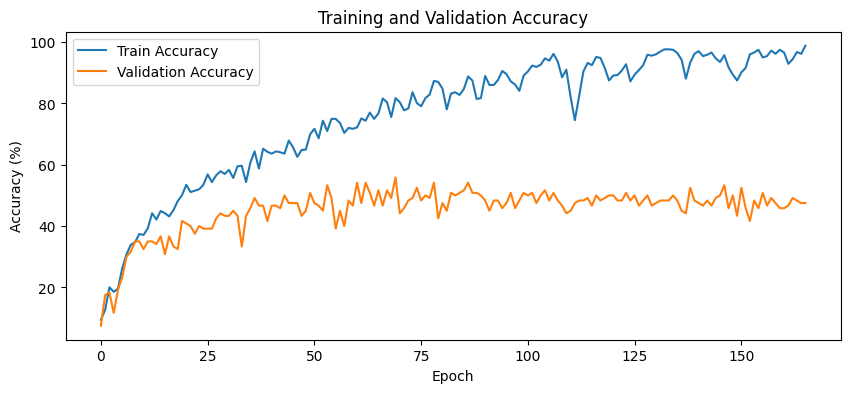

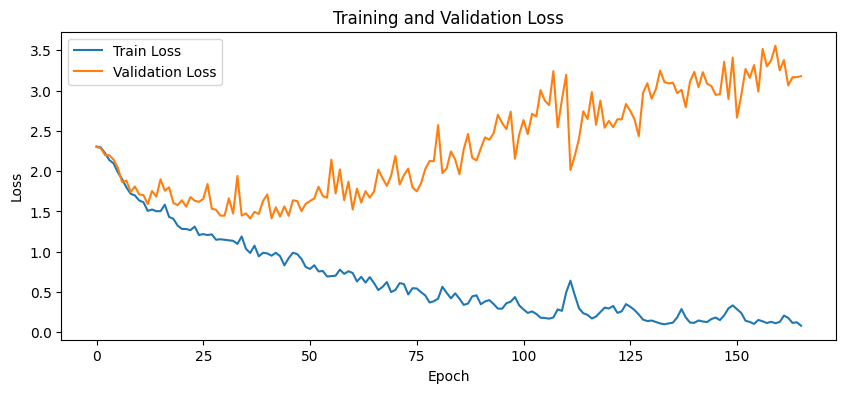

In [ ]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(10, 4))
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/genriflow/lstm_accuracy_plot.pdf')
plt.show()

torch.save(model.state_dict(), save_path)
# Plot Loss
plt.figure(figsize=(10, 4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/genriflow/lstm_loss_plot.pdf')
plt.show()
metrics = {
    'train_losses': train_losses,
    'val_losses': val_losses,
    'train_accuracies': train_accuracies,
    'val_accuracies': val_accuracies
}

with open('/content/drive/MyDrive/Colab Notebooks/genriflow/lstm_metrics.pkl', 'wb') as f:
    pickle.dump(metrics, f)

In [ ]:
# Evaluating the model
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
correct_preds = 0
total_preds = 0

with torch.no_grad():  # Disable gradient calculation during inference
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Compute the loss
        test_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

test_accuracy = correct_preds / total_preds * 100
print(f'Test Loss: {test_loss/len(test_loader):.4f}, Test Accuracy: {test_accuracy:.2f}%')

Test Loss: 2.4490, Test Accuracy: 56.50%
